# Benchmark for Multi-objective Evolutionary Algorithms (MOEAs)
> repetition is required. Maybe 5 seeds

For every problem and for every algorithm four different measures were obtained [@GP-DEMO]:

- number of exact evaluations performed during the optimization process, 
- final hypervolume, 
- duration of the optimization process, 
- number of nondominated solutions on the final front.

In [1]:
import time
import sys
import datetime
import logging
sys.path.append('..')

# --- Dependencies
import pygmo as pg
import numpy as np
import pandas as pd
# import dovpanda

import plotly
from plotly import graph_objs as go
from plotly import tools
import plotly.express as px

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score
# import sklearn.gaussian_process as gp
# from sklearn import clone
# from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
# from sklearn.ensemble import GradientBoostingRegressor

# from src.generator import SamplesGenerator
# from src.composite import PredictTutor, ModelsUnion
from src.ploting import plot_mo
# from src.search import Nsga2
# from src.hypothesis.custom_gp_kernel import KERNEL_MAUNA, KERNEL_SIMPLE, KERNEL_GPML

In [2]:
logging.basicConfig(filename='temp_moea.log',level=logging.INFO)

def make_nd_pop(pro, x,y):
    nd_front = pg.fast_non_dominated_sorting(y)[0][0]
    nd_x = x[nd_front]
    nd_y = y[nd_front]
    t_pop = pg.population(pro)
    for i, p_vector in enumerate(nd_x):
        t_pop.push_back(x=p_vector, f=nd_y[i])
    return t_pop

def experiment(problem_name: str,
               prob_id: int,
               prob_dim: int,
               obj: int,
               pop_size: int,
               gen: int,
               algo_name='nsga2',
               seed=None):

    result = {
        "problem_name": problem_name,
        "seed": seed,
        "problem_id": prob_id,
        "objectives": obj,
        "feature_dim": problem_dim,
        'algo_name': algo_name,
        "pop_size": pop_size,
        "generation": gen,
        "pop_ndf_x": '',
        "pop_ndf_f": '',
        "fevals": '',
        "evolve_time": '',
        "total_time": '',
        "date": '',
        "p_distance": '',
        "hypervolume": '',
        "ndf_space": '',
        "ndf_size": '',
        'error': '',
        'final': False
    }

    # ----------------------                                                            Initialize problem
    try:
        if problem_name is 'wfg':
            udp = pg.wfg(prob_id=prob_id, dim_dvs=prob_dim,
                         dim_obj=obj, dim_k=obj-1)
        elif problem_name is 'zdt':
            udp = pg.zdt(prob_id=prob_id, param=prob_dim)
        elif problem_name is 'dtlz':
            udp = pg.dtlz(prob_id=prob_id, dim=prob_dim, fdim=obj)
        prob = pg.problem(udp)
    except Exception as err:
        result['error'] = "Init problem: {}".format(err)
        return result

    t_start = time.time()
    # ----------------------                                                            Initial population
#     try:
#         pop = pg.population(prob=udp, size=pop_size, seed=seed)
#     except Exception as err:
#         result['error'] = "Init population: {}".format(err)
#         return result

    # ----------------------                                                            Initialization algorithm 
    try:
        algo = pg.algorithm(getattr(pg, algo_name)(gen=gen, seed=seed))
    except Exception as err:
        result['error'] = "Init algorithm: {}".format(err)
        return result

    # ----------------------                                                            Solving
    evolve_start = time.time()
    try:
        
        isl = pg.island(algo = algo, prob = udp, size=pop_size, udi = pg.mp_island(), seed=seed)
        isl.evolve()
        isl.wait()
        pop = isl.get_population()
        
#         pop = algo.evolve(pop)
         
        result["fevals"] = pop.problem.get_fevals()
        #This returns the first (i.e., best) non-dominated individual from population:
        nd_pop = make_nd_pop(prob, pop.get_x(), pop.get_f())
        
        score = udp.p_distance(nd_pop) if hasattr(udp, 'p_distance') else None
    except Exception as err:
        result['error'] = "Evolve: {}".format(err)
        return result

    # ----------------------                                                            Hypervolume
    try:
        hypervolume = pg.hypervolume(-nd_pop.get_f()
                                    ).compute([0]*nd_pop.problem.get_nobj())
        result['hypervolume'] = hypervolume or None
    except Exception as err:
        result['error'] = "Hypervolume: {}".format(err)
        return result
    
    # ----------------------                                                            Spacing metric
    #     The spacing metric aims at assessing the spread (distribution)
    # of vectors throughout the set of nondominated solutions. 
    try:
        dist = pg.crowding_distance(points = nd_pop.get_f())
        not_inf_dist = dist[np.isfinite(dist)]
        mean_dist = np.mean(not_inf_dist)
        space_m = (sum([(mean_dist - d)**2 for d in not_inf_dist])/(len(not_inf_dist)-1))**(1/2)
        result["ndf_space"] = space_m
    except Exception as err:
        result['error'] = "Spacing metric: {}".format(err)
        return result

    # ----------------------                                                            Write results
    
    logging.debug('This message should go to the log file')
    logging.info('So should this')
    logging.warning('And this, too')
    try:
        t_end = time.time()

        result["problem_name"] = pop.problem.get_name()
        result["objectives"] = pop.problem.get_nobj()
        result["feature_dim"] = pop.problem.get_nx()
        result["pop_ndf_x"] = nd_pop.get_x().tolist()
        result["pop_ndf_f"] = nd_pop.get_f().tolist()
        result["evolve_time"] = t_end - evolve_start
        result["total_time"] = t_end - t_start
        result["date"] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
        result["final"] = True
        result['algo_name'] = algo_name
        result["p_distance"] = score or None
        result["ndf_size"] = len(nd_pop.get_f())
        

    except Exception as err:
        result['error'] = "Write results: {}".format(err)

    return result

In [6]:
DIM = 2
ID = 1
OBJ = 2

# --- Problem
udp = pg.wfg(prob_id=ID, dim_dvs=DIM, dim_obj=OBJ, dim_k=OBJ-1)
# udp = pg.zdt(prob_id=ID, param=DIM)
pro = pg.problem(udp)

pop = pg.population(pro, size=100, seed=214)

print("Hypervolume: {}".format(pg.hypervolume(-pop.get_f()).compute([0,0])))
pg.plot_non_dominated_fronts(pop.get_f())

nd_pop = make_nd_pop(pro, pop.get_x(), pop.get_f())
dist = pg.crowding_distance(points = nd_pop.get_f())
not_inf_dist = dist[np.isfinite(dist)]
mean_dist = np.mean(not_inf_dist)
(sum([(mean_dist - d)**2 for d in not_inf_dist])/(len(not_inf_dist)-1))**(1/2)

Hypervolume: 4.11442852120591


0.34974418435307253

Hypervolume: 6.251870605168537


0.013438098839049532

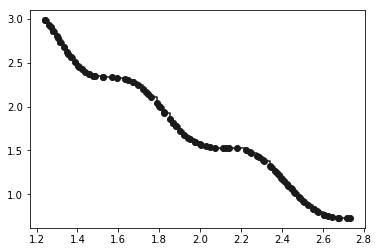

In [7]:
# NSGA 2
pop = pg.population(pro, size=100, seed=214)
algo = pg.algorithm(pg.nsga2(gen=300, seed=2114))
pop = algo.evolve(pop)      

print("Hypervolume: {}".format(pg.hypervolume(-pop.get_f()).compute([0,0])))
pg.plot_non_dominated_fronts(pop.get_f())

nd_pop = make_nd_pop(pro, pop.get_x(), pop.get_f())
dist = pg.crowding_distance(points = nd_pop.get_f())
not_inf_dist = dist[np.isfinite(dist)]
mean_dist = np.mean(not_inf_dist)
(sum([(mean_dist - d)**2 for d in not_inf_dist])/(len(not_inf_dist)-1))**(1/2)

Hypervolume: 4.297083944438444


0.043661473276195725

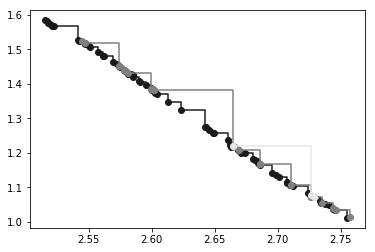

In [8]:
# nspso
pop = pg.population(pro, size=100, seed=214)
algo = pg.algorithm(pg.nspso(gen=300, seed=2114))
pop = algo.evolve(pop)      

print("Hypervolume: {}".format(pg.hypervolume(-pop.get_f()).compute([0,0])))
pg.plot_non_dominated_fronts(pop.get_f())

nd_pop = make_nd_pop(pro, pop.get_x(), pop.get_f())
dist = pg.crowding_distance(points = nd_pop.get_f())
not_inf_dist = dist[np.isfinite(dist)]
mean_dist = np.mean(not_inf_dist)
(sum([(mean_dist - d)**2 for d in not_inf_dist])/(len(not_inf_dist)-1))**(1/2)

Hypervolume: 4.4037955693411


0.09379724055262705

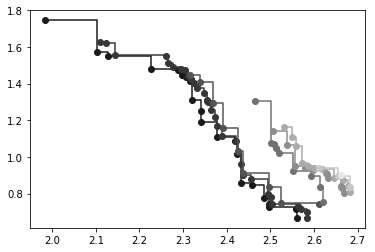

In [9]:
# maco
pop = pg.population(pro, size=100, seed=214)
algo = pg.algorithm(pg.maco(gen=3000, seed=2114))
pop = algo.evolve(pop)      

print("Hypervolume: {}".format(pg.hypervolume(-pop.get_f()).compute([0,0])))
pg.plot_non_dominated_fronts(pop.get_f())

nd_pop = make_nd_pop(pro, pop.get_x(), pop.get_f())
dist = pg.crowding_distance(points = nd_pop.get_f())
not_inf_dist = dist[np.isfinite(dist)]
mean_dist = np.mean(not_inf_dist)
(sum([(mean_dist - d)**2 for d in not_inf_dist])/(len(not_inf_dist)-1))**(1/2)

Hypervolume: 6.586280238834825


0.15512649499143405

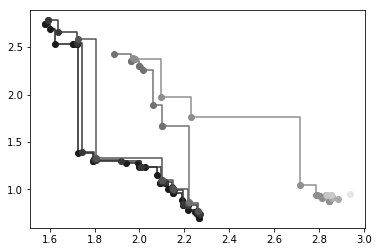

In [10]:
# moead
pop = pg.population(pro, size=100, seed=214)
algo = pg.algorithm(pg.moead(gen=3000, seed=2114))
pop = algo.evolve(pop)      

print("Hypervolume: {}".format(pg.hypervolume(-pop.get_f()).compute([0,0])))
pg.plot_non_dominated_fronts(pop.get_f())


nd_pop = make_nd_pop(pro, pop.get_x(), pop.get_f())
dist = pg.crowding_distance(points = nd_pop.get_f())
not_inf_dist = dist[np.isfinite(dist)]
mean_dist = np.mean(not_inf_dist)
(sum([(mean_dist - d)**2 for d in not_inf_dist])/(len(not_inf_dist)-1))**(1/2)

Hypervolume: 5.311930659503753


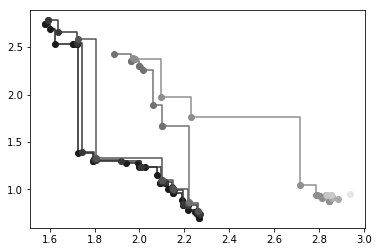

In [11]:
# moead
pop = pg.population(pro, size=100, seed=214)
algo = pg.algorithm(pg.moead(gen=3000, seed=2114))
pop = algo.evolve(pop)      

ndf_front = pg.fast_non_dominated_sorting(pop.get_f())[0][0]
print("Hypervolume: {}".format(pg.hypervolume(-pop.get_f()[ndf_front]).compute([0,0])))
pg.plot_non_dominated_fronts(pop.get_f())


Hypervolume: 7.381633816334992


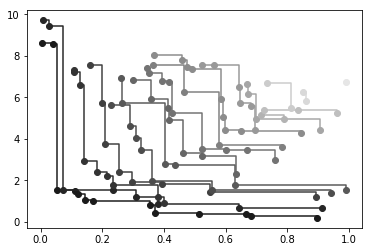

In [12]:
DIM = 2
ID = 1
OBJ = 2

# --- Problem
# udp = pg.wfg(prob_id=ID, dim_dvs=DIM, dim_obj=OBJ, dim_k=OBJ-1)
udp = pg.zdt(prob_id=ID, param=DIM)
pro = pg.problem(udp)

pop = pg.population(pro, size=100, seed=214)

print("Hypervolume: {}".format(pg.hypervolume(-pop.get_f()).compute([0,0])))
pg.plot_non_dominated_fronts(pop.get_f())
pop = pg.population(pro, size=100, seed=214)

In [ ]:
pop.problem.get_fevals()

In [ ]:
dt = pg.crowding_distance(points = nd_pop.get_f())
not_inf = dt[np.isfinite(dt)]
# mean = [np.mean(not_inf)]*len(not_inf)
mean = np.mean(not_inf)
(sum([(mean - d)**2 for d in not_inf])/(len(not_inf)-1))**(1/2)

In [ ]:
pg.crowding_distance(points = nd_pop.get_f())

In [ ]:
def make_nd_pop(pro, x,y):
    nd_front = pg.fast_non_dominated_sorting(y)[0][0]
    nd_x = x[nd_front]
    nd_y = y[nd_front]
    t_pop = pg.population(pro)
    for i, p_vector in enumerate(nd_x):
        t_pop.push_back(x=p_vector, f=nd_y[i])
    return t_pop


new_pop = make_nd_pop(pro, pop.get_x(), pop.get_f())
pg.plot_non_dominated_fronts(new_pop.get_f())
udp.p_distance(new_pop)
